In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\Assignment2\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Useful stuff

In [4]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [5]:
df_ground_truth = pd.read_csv('./train.csv', index_col=0)
df_ground_truth.head()

,bounding_boxes
frame_id,
1,0 225 214 317 0 172 345 254 285 240 155 131 70...
2,0 254 190 293 0 169 338 271 276 238 160 137 70...
3,0 306 59 241 0 155 306 318 235 233 191 149 713...
4,0 143 239 298 164 223 240 172 721 293 94 76 57...
5,0 217 137 270 55 209 323 208 731 296 99 79 573...


In [6]:
data_root = './train/'
test_root = './test/'
_N = 202 # number of frames

def format_id(frame):
    assert _N >= frame
    return '%03d' % frame

def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return imread(os.path.join(root, format_id(frame)+'.jpg'))


## Sampling of positive and negative examples

In [7]:
def get_positive_sample_and_image(frame_id, thresh = 0.2):
    positive_samples = []
    bbs = list(map(int, df_ground_truth.loc[frame_id].bounding_boxes.split(" ")))
    bbs = np.array_split(bbs, len(bbs) / 4)
    img = read_frame(data_root, frame_id)
    for x, y, dx, dy in bbs:
        positive_sample = img[y:y+dy,x:x+dx]
        positive_samples.append(positive_sample)

    # crop larger boxes
    for x, y, dx, dy in bbs:
        r = np.random.rand(1)
        if r <= thresh:
            try:
                additional_dx_up = np.random.randint(0,int(dx/2))
                additional_dx_down = np.random.randint(0,int(dx/2))
                additional_dy_up = np.random.randint(0,int(dy/2))
                additional_dy_down = np.random.randint(0,int(dy/2))
                positive_sample = img[max(0,y+additional_dy_down):min(y+dy+additional_dy_up, img.shape[0]),max(0,x+additional_dx_down):min(x+dx+additional_dx_up, img.shape[1])]
                positive_samples.append(positive_sample)
            except:
                continue

    # crop smaller boxes
    for x, y, dx, dy in bbs:
        r = np.random.rand(1)
        if r <= thresh:
            try:
                additional_dx_up = np.random.randint(0,int(dx/2))
                additional_dx_down = np.random.randint(0,dx-additional_dx_up)
                additional_dy_up = np.random.randint(0,int(dy/2))
                additional_dy_down = np.random.randint(0,dy-additional_dy_up)
                positive_sample = img[y+additional_dy_down:y+dy-additional_dy_up,x+additional_dx_down:x+dx-additional_dx_up]
                if positive_sample.shape[0] >= 50 and positive_sample.shape[1] >= 50:
                    positive_samples.append(positive_sample)
            except:
                continue
    return(positive_samples, bbs, img)

In [8]:
def get_negative_sample(img, positive_bbs, number_of_negative_samples):
    # get negative sample
    dx_list = [box[2] for box in positive_bbs]
    dy_list = [box[3] for box in positive_bbs]
    min_dx, max_dx = np.min(dx_list), np.max(dx_list)
    min_dy, max_dy = np.min(dy_list), np.max(dy_list)

    number_of_neg_examples = 0
    negative_samples = []
    negative_bbs = []
    gray_img = rgb2gray(img)
    for x, y, dx, dy in positive_bbs:
        gray_img[y:y+dy,x:x+dx] = 1000000

    i = 0
    while (number_of_neg_examples <= number_of_negative_samples) and (i <= number_of_negative_samples + 3000):
        i+=1
        try:
            dx = np.random.randint(min_dx,max_dx)
            dy = np.random.randint(max(min_dy, dx//2), min(max_dy,2*dx))
            x = np.random.randint(dx,img.shape[1]-dx)
            y = np.random.randint(dy,img.shape[0]-dy)
            crop_gray = gray_img[y:y+dy,x:x+dx]
            if np.max(crop_gray) <= 1000:
                crop = img[y:y+dy,x:x+dx]
                negative_samples.append(crop)
                negative_bbs.append([x,y,dx,dy])
                gray_img[y:y+dy,x:x+dx] = 1000000
            number_of_neg_examples = len(negative_samples)
        except:
            continue
    return(negative_samples, negative_bbs)

In [9]:
def sampling():
    total_positive_samples = []
    total_negative_samples = []
    for frame_id in tqdm(df_ground_truth.index, position = 0):
        positive_samples, positive_bbs, img = get_positive_sample_and_image(frame_id)
        negative_samples, negative_bbs = get_negative_sample(img, positive_bbs, len(positive_bbs)+20)
        for img in positive_samples:
            total_positive_samples.append(cv2.resize(img, (64,64)))
        for img in negative_samples:
            total_negative_samples.append(cv2.resize(img, (64,64)))
    return(total_positive_samples, total_negative_samples)

In [10]:
total_positive_samples, total_negative_samples = sampling()

100%|██████████| 202/202 [00:09<00:00, 21.66it/s]


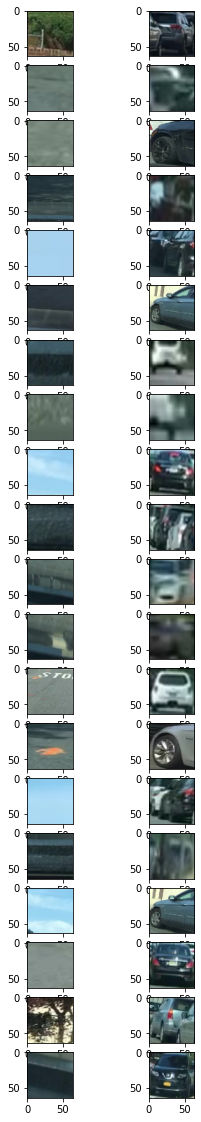

In [11]:
# samples visualisation
number_of_positive_samples = len(total_positive_samples)
number_of_negative_samples = len(total_negative_samples)
fig, ax = plt.subplots(20,2,figsize=(4, 20))
for i in range(20):
    for j in range(2):
        if j == 0:
            img = total_negative_samples[np.random.randint(number_of_negative_samples)]
        else:
            img = total_positive_samples[np.random.randint(number_of_positive_samples)]
        ax[i][j].imshow(img)

## Data Augmentation

In [12]:
from skimage.filters import gaussian
class Transfo:
    def __init__(self, img):
        self.img = img.astype(np.uint8)

    def increase_brightess(self):
        self.img = np.clip(self.img*1.2, 0, 255).astype(np.uint8)

    def add_noise(self):
        row,col,ch = self.img.shape         
        #White
        pts_x = np.random.randint(0, col-1 , 100) #From 0(col-1)Make a thousand random numbers up to
        pts_y = np.random.randint(0, row-1 , 100)
        self.img[(pts_y,pts_x)] = (255,255,255) #y,Note that the order is x

        #black
        pts_x = np.random.randint(0, col-1 , 100)
        pts_y = np.random.randint(0, row-1 , 100)
        self.img[(pts_y,pts_x)] = (0,0,0)

    def distort(self):
        ###Distort the image
        self.img = cv2.flip(self.img, 1) #Flip horizontally
        self.img = cv2.flip(self.img, 0) #Invert vertically


    def blur(self):
        blured_img = 255*gaussian(self.img, 1)
        self.img = blured_img.astype(np.uint8)

In [13]:
def random_augmentation(img):
    new_img = Transfo(img)
    number_of_transfo = np.random.randint(1,3)
    transfo_list = [new_img.increase_brightess, new_img.blur, new_img.distort, new_img.add_noise]
    transfo_to_apply = np.random.choice(transfo_list,number_of_transfo,replace=False)
    for transfo in transfo_to_apply:
        transfo()
    return(new_img.img)

In [14]:
new_positive_samples = []
new_negative_samples = []
thresh = 0.4
for img in tqdm(total_positive_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_positive_samples.append(new_img)

for img in tqdm(total_negative_samples, position = 0):
    r = np.random.rand(1)
    if r <= thresh:
        new_img = random_augmentation(img)
        new_negative_samples.append(new_img)

total_positive_samples.extend(new_positive_samples)
total_negative_samples.extend(new_negative_samples)

  0%|          | 0/3635 [00:00<?, ?it/s]c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\Assignment2\venv\lib\site-packages\skimage\_shared\utils.py:293: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)
100%|██████████| 7210/7210 [00:00<00:00, 10649.85it/s]


In [15]:
print(f"number of positive samples: {len(total_positive_samples)}")
print(f"number of negative samples: {len(total_negative_samples)}")

number of positive samples: 5089
number of negative samples: 10132


## Features computation

In [16]:
from skimage import exposure
from skimage import feature

positive_features = []
negative_features = []
for img in tqdm(total_positive_samples, position = 0):
    (H, hogImage) = feature.hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    positive_features.append(H)
for img in tqdm(total_negative_samples, position = 0):
    (H, hogImage) = feature.hog(img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    negative_features.append(H)



100%|██████████| 10132/10132 [03:20<00:00, 50.41it/s]


In [17]:
from sklearn.model_selection import train_test_split
X = np.array(positive_features+negative_features)
y = np.array([1 for i in range(len(positive_features))]+[0 for i in range(len(negative_features))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle = True)

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#clf = SVC()
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"accuracy: {acc}")

c:\Users\33631\Documents\Etudes\centrale 3A\computer vision\Assignment2\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy: 0.9405582922824303


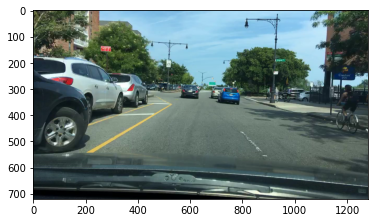

In [25]:
test_img = read_frame(data_root, 1)
plt.imshow(test_img)

In [26]:
pred_array = np.zeros((test_img.shape[0], test_img.shape[1]), dtype = float)
crop_pos = []
crop_neg = []
for size in tqdm(range(50,100,10), position = 0):
    for i in range(size, test_img.shape[0], int(size*0.75)):
        for j in range(size, test_img.shape[1], int(size*0.75)):
            crop = test_img[i-size:i, j-size:j,::]
            crop = cv2.resize(crop, (64,64))
            (H, hogImage) = feature.hog(crop, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=True, channel_axis=-1)
            pred = clf.predict([H])
            if pred == 0:
                crop_neg.append(crop)
            else:
                crop_pos.append(crop)
            pred_array[i-size:i, j-size:j] += pred




100%|██████████| 5/5 [00:36<00:00,  7.34s/it]


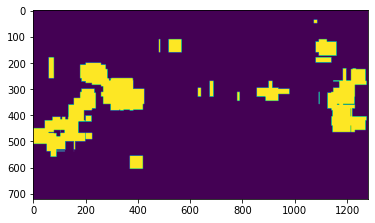

In [31]:
plt.imshow(pred_array>1)

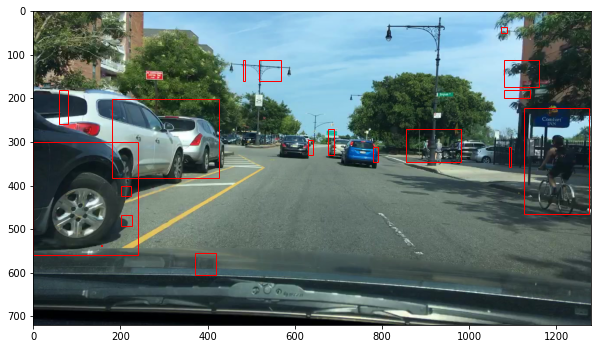

In [28]:
import cv2

# Grayscale then Otsu's threshold
gray = pred_array.astype("uint8")
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
bbs = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    bbs.append([x,y,w,h])

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in bbs:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_img)

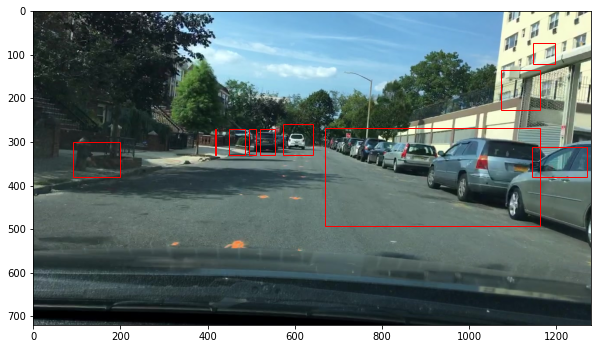

In [23]:
import cv2

# Grayscale then Otsu's threshold
gray = pred_array.astype("uint8")
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

# Find contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
bbs = []
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    bbs.append([x,y,w,h])

fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in bbs:
    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(test_img)

In [24]:
data_root = './train/'

_N = 202 # number of frames

def format_id(frame):
    assert _N >= frame
    return '%03d' % frame

def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return imread(os.path.join(root, format_id(frame)+'.jpg'))

def show_annotation(pos_bbs, neg_bbs, frame):
    assert frame <= _N
    img = read_frame(data_root, frame)

    fig, ax = plt.subplots(figsize=(10, 8))

    for x, y, dx, dy in pos_bbs:
        rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    for x, y, dx, dy in neg_bbs:    
        rect = patches.Rectangle((x, y), dx, dy, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    ax.imshow(img)
    ax.set_title('Annotations for frame {}.'.format(frame))

from ipywidgets import interact, widgets
from IPython.display import display

show_annotation(bbs, negative_samples, 1)

NameError: name 'negative_samples' is not defined